In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

import pickle
from itertools import zip_longest

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters,
    MeanMinLoss
)

from sde.experiment_reports import (
    sample_data,
    plot_results_functions,
    histogram_data_ex6,
    plot_histogram_ex6
)

from gillespie.sir import SIRG

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# notebook parameters
random_seed = 1
n_dimensions = 2

# SIR model paramters
k1, k2 = 1, 1
N = 1024

# training data parameters
n_trajectories = 250
n_time_per_trajectory = .2
time_step = 1e-4
n_skip_steps = 10 # how many time steps to skip of the training data, to artificially increase time step



In [4]:
# create Gillespie training data
rng = np.random.default_rng(random_seed)

sirg = SIRG(N=N, k1=k1, k2=k2, k3=0)

x_data = []
y_data = []
times = []
step_sizes = []

y0_all = []

for k in range(n_trajectories):
    # randomly sample the unit cube
    y0 = rng.uniform(low=0.0, high=1.0, size=(3,))

    # transform to sample more points on the boundary
    # y0 = (np.tanh((y0-.5)*5)+1)/2

    # make sure we only sample admissible initial conditions
    y0 = np.clip(y0, 0, 1)
    y0 = y0/np.sum(y0)

    # only take the first two
    y0 = y0[:2]

    y0_all.append(y0)

y0_all = np.row_stack(y0_all)
time_g, y = sirg.simulate(y0_all, time_max = n_time_per_trajectory, time_step=time_step)


for k in range(len(y)):
    # skip simulated time steps for the training data, so that the individual points are further apart in time
    time_g[k] = time_g[k][::n_skip_steps]
    y[k] = y[k][::n_skip_steps,:]

    if len(time_g[k]) > 2:
        times.extend(time_g[k][:-1])
        step_sizes.extend(np.gradient(time_g[k])[:-1])
        x_data.append(y[k][:-1,:])
        y_data.append(y[k][1:,:])

x_data = np.row_stack(x_data)
y_data = np.row_stack(y_data)
step_sizes = np.array(step_sizes)
times = np.array(times)

def theta02(traj):
    """
    Convert theta12 data to theta02 data (theta0 has "more interesting" trajectories)
    """
    traj_new = traj.copy()
    traj_new[:,0] = 1-(traj[:,0]+traj[:,1])
    return traj_new


# work with (theta0,theta2) data instead of (theta1,theta2) data (the SDE equations we use to compare later are in terms of theta0,2)
x_data = theta02(x_data)
y_data = theta02(y_data)


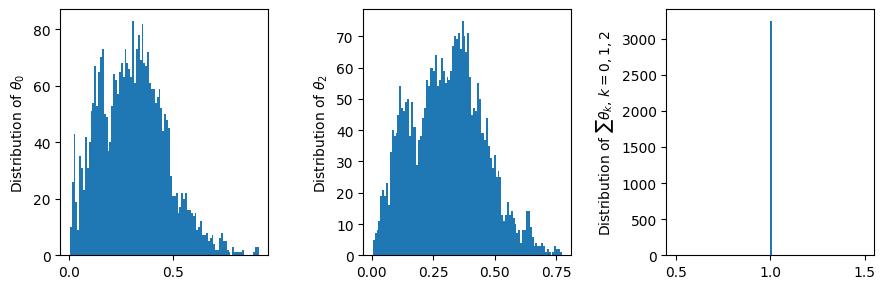

In [8]:
fig,ax=plt.subplots(1,3, figsize=(9,3))
ax[0].hist(x_data[:,0], 100);
ax[0].set_ylabel(r"Distribution of $\theta_0$")
ax[1].hist(x_data[:,1], 100);
ax[1].set_ylabel(r"Distribution of $\theta_2$")
ax[2].hist(x_data[:,0]+x_data[:,1]+(1-(x_data[:,0]+x_data[:,1])), 100);
ax[2].set_ylabel(r"Distribution of $\sum\theta_k$, $k=0,1,2$")
fig.tight_layout()

fig.tight_layout()

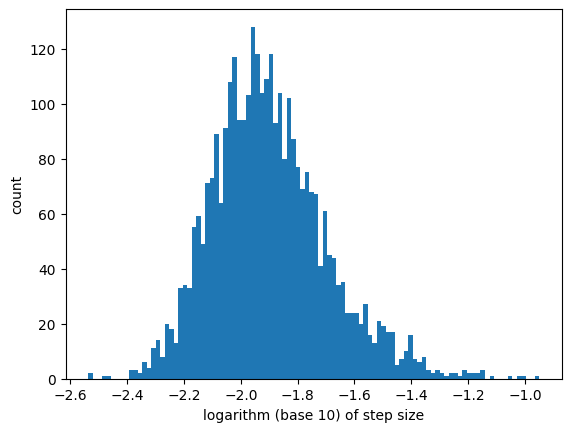

In [9]:
# visualize the different step sizes
fig,ax=plt.subplots(1,1,)
ax.hist(np.log(step_sizes)/np.log(10), 100);
ax.set_xlabel("logarithm (base 10) of step size");
ax.set_ylabel("count");

In [10]:
"""
Plot estimations of the SDE paths in theta space.
Here, the results should match up (except for the differences due to them being sample paths),
even though we work in the transformed variable xi with the network.
"""

# EXAMPLE SIR 1 for comparison
def true_drift(x):
    """
    drift for theta 0 and 2.
    """
    theta0 = np.clip(x[:, 0], 0, 1)
    theta2 = np.clip(x[:, 1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    return np.stack([-r1, r2], axis=1)


def true_diffusivity(x):
    """
    Note that the diffusivity here includes _no_ off-diagonal terms!
    So we can just use the diagonal version of the codes.
    """
    theta0 = np.clip(x[:, 0], 0, 1)
    theta2 = np.clip(x[:, 1], 0, 1-theta0)
    theta1 = np.clip(1 - theta0 - theta2, 0, 1)
    r1 = 4*k1*theta0*theta1
    r2 = k2*theta1
    #return np.stack([np.sqrt(r1/N), np.sqrt(r2/N)], axis=1)
    return np.transpose(np.array([[np.sqrt(r1/N), np.zeros(x.shape[0])], [np.zeros(x.shape[0]), np.sqrt(r2/N)]]))


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


In [11]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**6, 
                                M_min=10,
                                M_max=200,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


drift epoch: 22


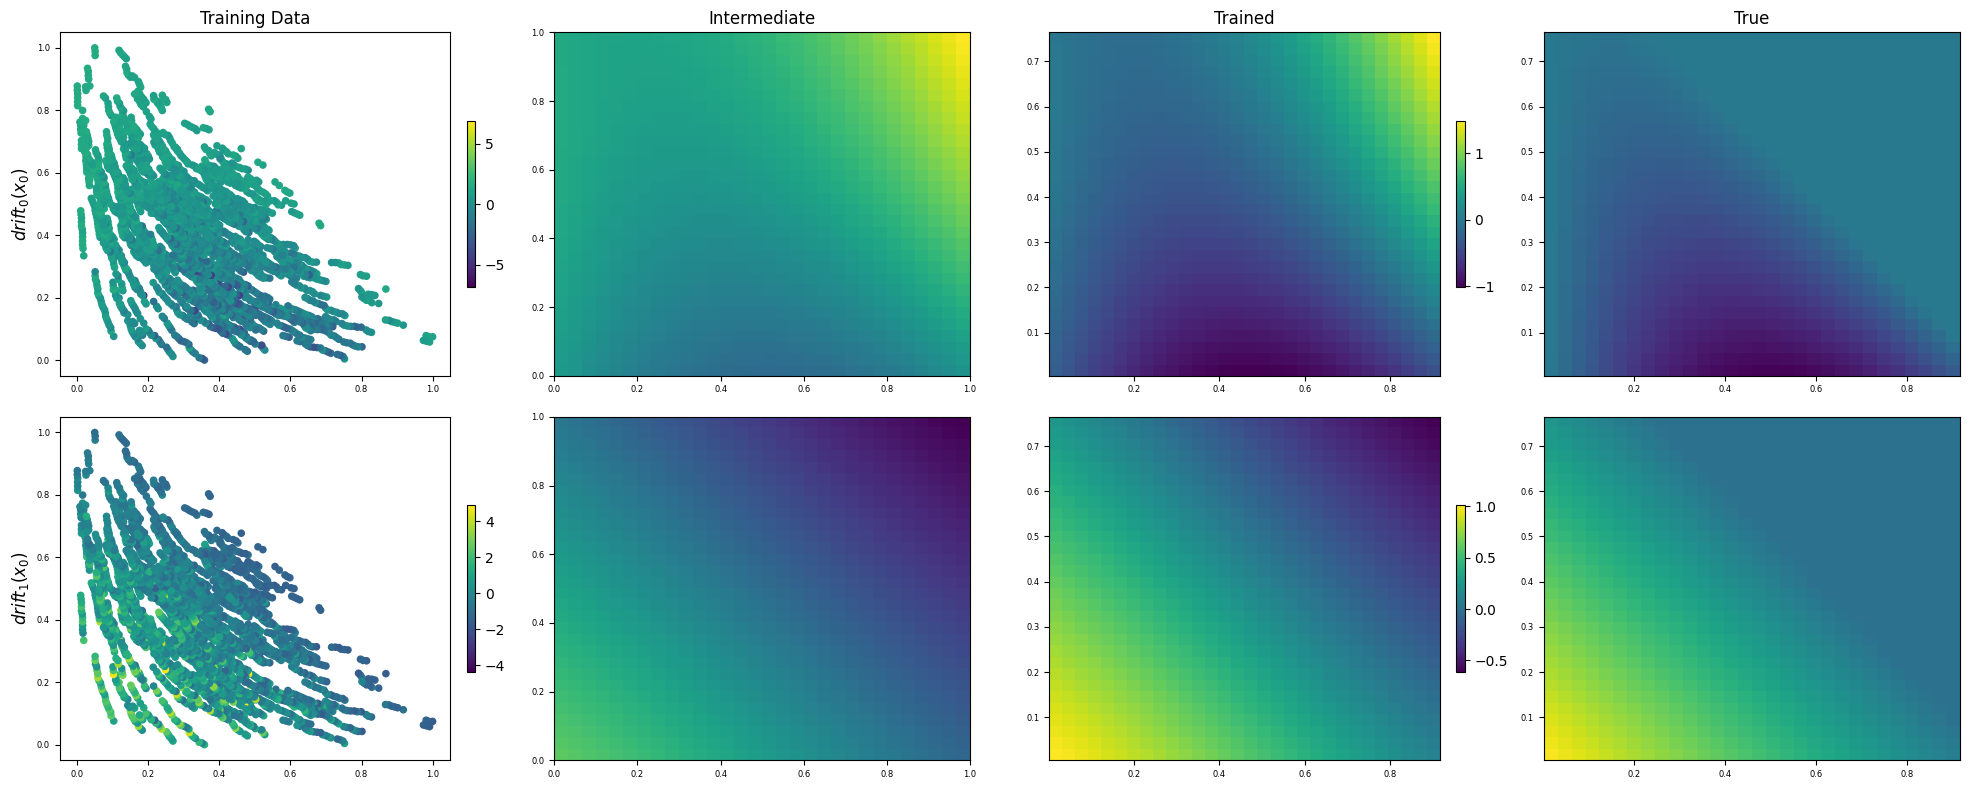

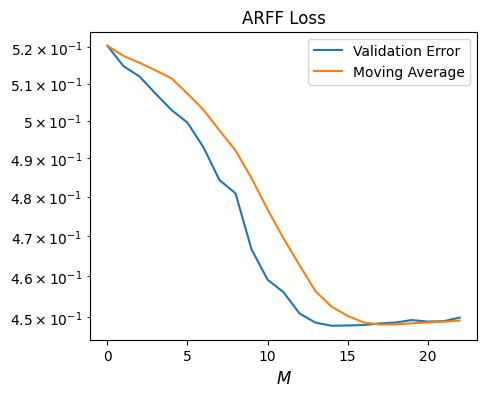

diff epoch: 26


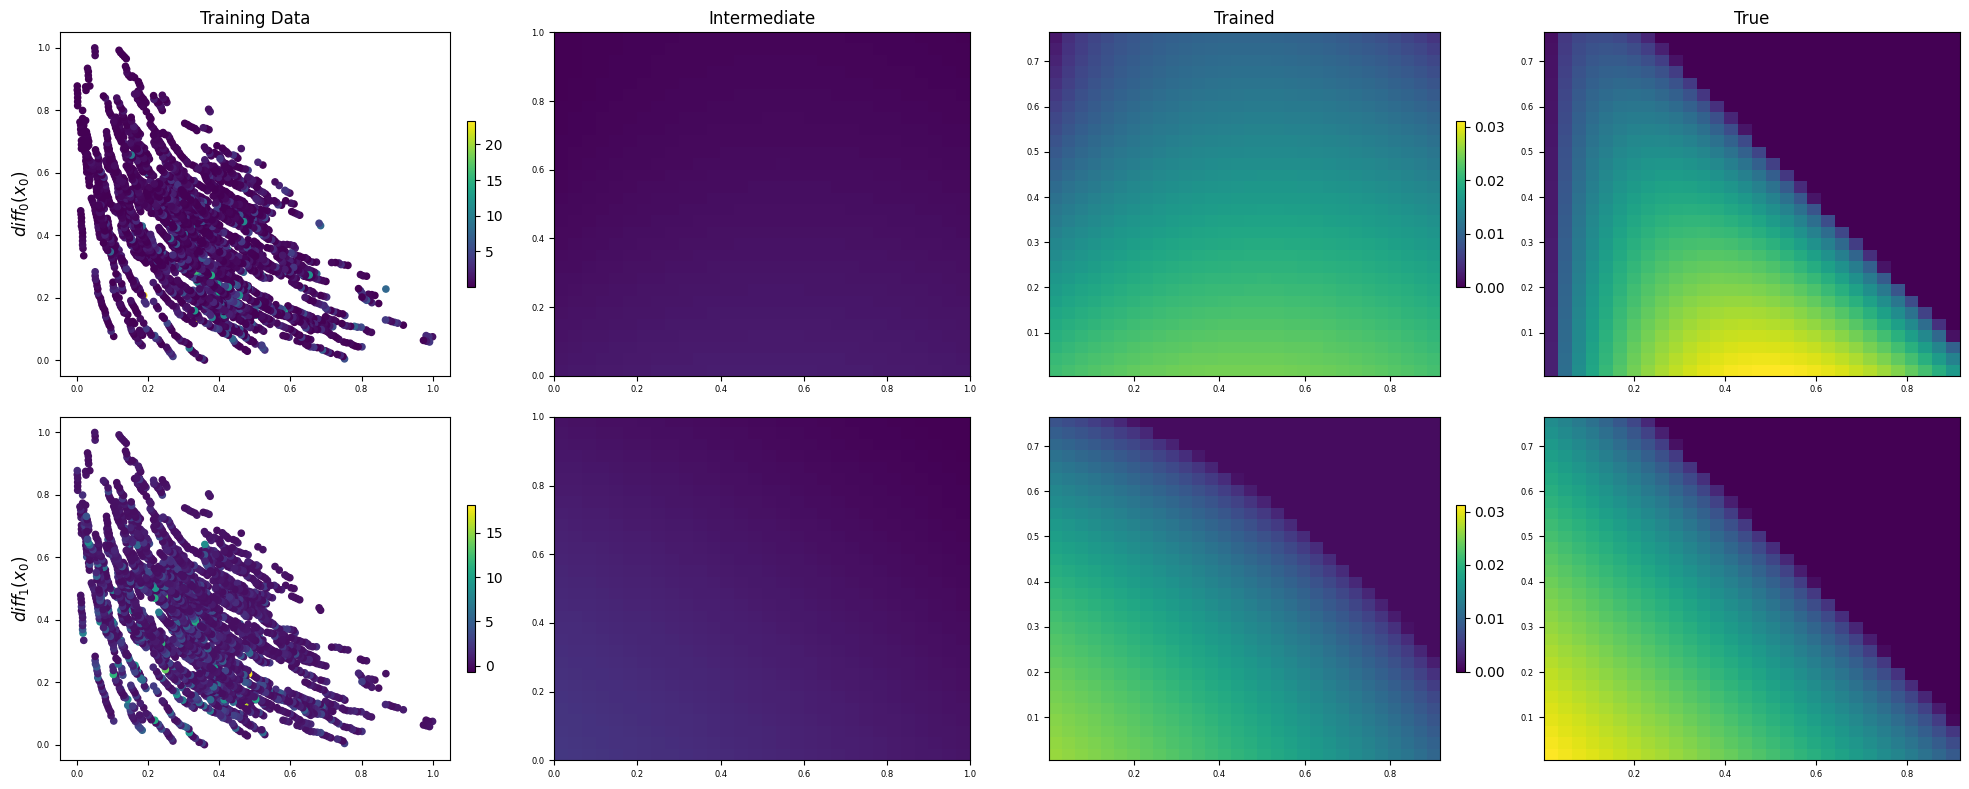

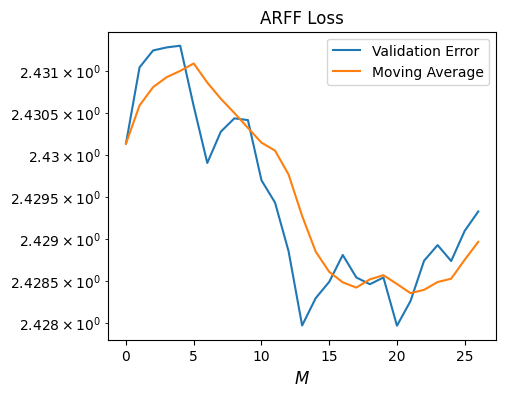

Observed loss: -9.682137884473022
Observed validation loss: -9.717760719969139
True function validation loss: -9.746829046084025
Training time: 1.2579820156097412


2025-05-26 02:23:02.372965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-26 02:23:02.373073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-26 02:23:02.373139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-26 02:23:02.

In [13]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusivity, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1067: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/douglaoj/miniconda

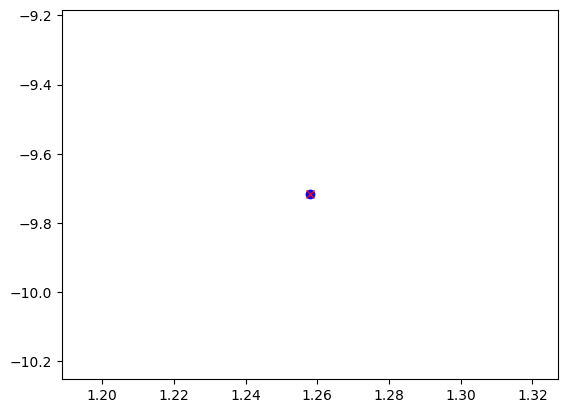

In [14]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, f"{filename}.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")


figures_per_row 2


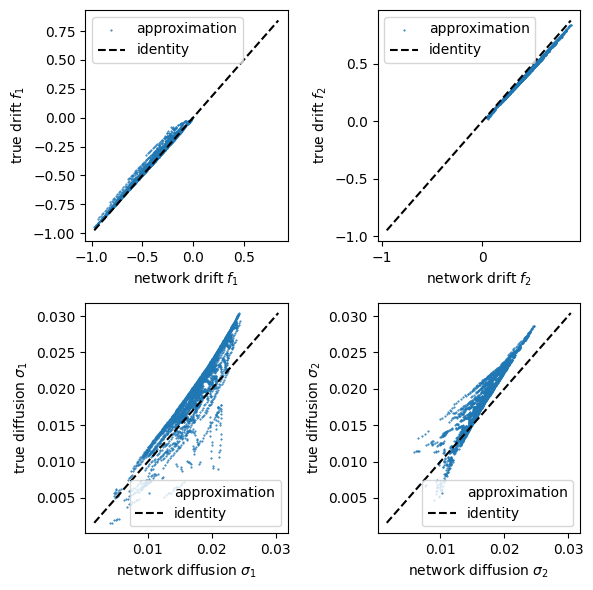

In [16]:
ax = plot_results_functions(SAT.drift_diffusion, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

# output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
# output_path = os.path.join(output_dir, f"{filename}")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [17]:
# def plot_histogram2(y, time_g, max_time):
#     M = len(y)  # Number of trajectories
    
#     # Flatten all time and y values across trajectories
#     time_all = np.concatenate(time_g)  # Shape (M*N,)
#     y_all = np.concatenate(y, axis=0)  # Shape (M*N, 2)
    
#     # Adjust the bin edges such that the center of the last bin is at max_time
#     bins_0 = np.linspace(time_all.min(), max_time, 100)
#     # Ensure that the last bin's center is at max_time
#     bins_0[-1] = max_time
    
#     bins_1 = np.linspace(0, 1, 100)
    
#     fig, axes = plt.subplots(2, 1, figsize=(5, 8), gridspec_kw={'hspace': 0.12})
    
#     for d in range(2):
#         hist, x_edges, y_edges = np.histogram2d(time_all, y_all[:, d], bins=[bins_0, bins_1])
        
#         axes[d].imshow(
#             hist.T,
#             origin='lower',
#             cmap='inferno',
#             aspect='auto',
#             extent=[time_all.min(), max_time, 0, 1]
#         )
#         axes[d].set_ylabel(f"$y_{d}$")
    
#     fig.supxlabel("Time (s)")
#     plt.show()





In [21]:

# training data parameters
n_trajectories = 10000
n_time_per_trajectory = 5
time_step = 1e-4
n_skip_steps = 10 # how many time steps to skip of the training data, to artificially increase time step

random_seed = 1

# create Gillespie training data
rng = np.random.default_rng(random_seed+1)

sirg = SIRG(N=N, k1=k1, k2=k2, k3=0)

x_data = []
y_data = []
times = []
step_sizes = [0] * n_trajectories

y0_all = []

for k in range(n_trajectories):
    # randomly sample the unit cube
    y0 = rng.uniform(low=0.0, high=1.0, size=(3,))

    # transform to sample more points on the boundary
    # y0 = (np.tanh((y0-.5)*5)+1)/2

    # make sure we only sample admissible initial conditions
    y0 = np.clip(y0, 0, 1)
    y0 = y0/np.sum(y0)

    # only take the first two
    y0 = y0[:2]

    y0_all.append(y0)

y0_all = np.row_stack(y0_all)
time_g, y = sirg.simulate(y0_all, time_max = n_time_per_trajectory, time_step=time_step)

for k in range(len(y)):
    # skip simulated time steps for the training data, so that the individual points are further apart in time
    time_g[k] = time_g[k][::n_skip_steps]
    y[k] = y[k][::n_skip_steps,:]

    y[k][:,0] = 1-(y[k][:,0]+y[k][:,1])

y_ = y.copy()

p = 0
for l in range(len(y_)):
    if y_[l].shape[0] < 2:
        y.pop(l-p)
        time_g.pop(l-p)
        p += 1


step_sizes = [0] * len(time_g)
step_sizes_len = [0] * len(time_g)
for k in range(len(time_g)):
    step_sizes[k] = np.gradient(time_g[k])[:-1]
    step_sizes_len[k] = len(step_sizes[k]) 

sorted_indices = np.argsort(step_sizes_len)[::-1]
time_g_sorted = [time_g[i] for i in sorted_indices]
step_sizes_sorted = [step_sizes[i] for i in sorted_indices]
y_sorted = [y[i] for i in sorted_indices]

step_sizes_layered = [np.array([x for x in group if x is not None]) for group in zip_longest(*step_sizes_sorted, fillvalue=None)]
time_g_layered = [np.array([x for x in group if x is not None]) for group in zip_longest(*time_g_sorted, fillvalue=None)]
y_layered = [np.array([x for x in group if x is not None]) for group in zip_longest(*y_sorted, fillvalue=None)]

X = histogram_data_ex6(SAT.drift_diffusion, y, step_sizes_layered, n_dimensions, rng, ARFF=True)

output_dir = os.path.join(script_dir, 'histogram_data')

# hist_data = {'traj_time': n_time_per_trajectory}
# with open(os.path.join(output_dir, "ex6 - SIRGillespie ints.pkl"), 'wb') as f:
#     pickle.dump(hist_data, f)

# with open(os.path.join(output_dir, "ex6 - SIRGillespie true.pkl"), 'wb') as f:
#     pickle.dump(y_sorted, f)

# with open(os.path.join(output_dir, "ex6 - SIRGillespie ARFF.pkl"), 'wb') as f:
#     pickle.dump(X, f)

# with open(os.path.join(output_dir, "ex6 - SIRGillespie times.pkl"), 'wb') as f:
#     pickle.dump(time_g_sorted, f)


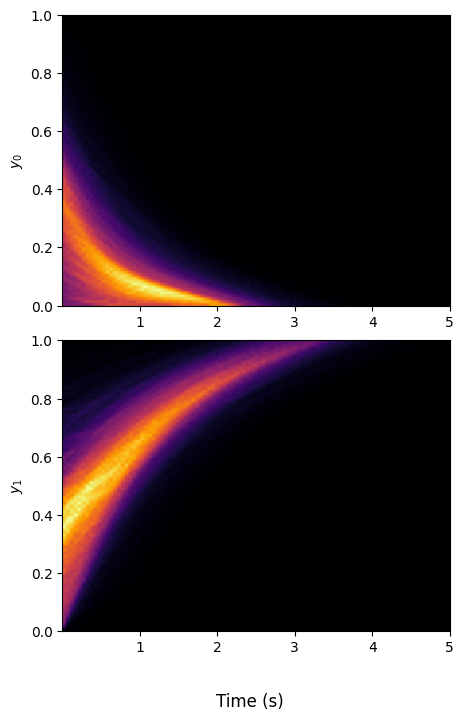

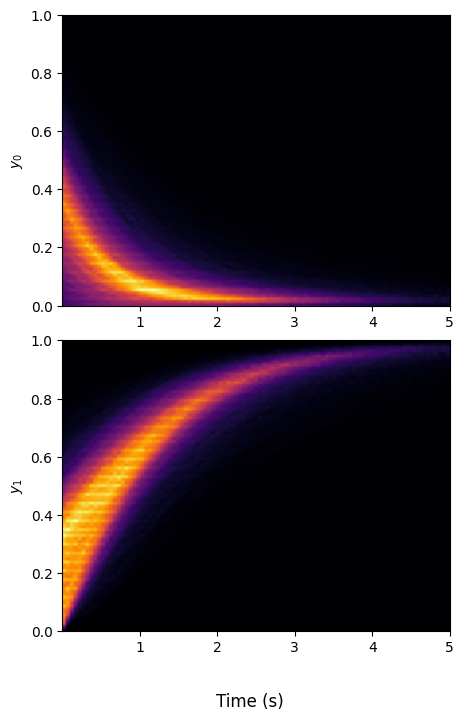

In [24]:
plot_histogram_ex6(X, time_g_layered, n_time_per_trajectory)
plot_histogram_ex6(y_sorted, time_g_sorted, n_time_per_trajectory)

In [15]:
# def histogram_data(drift_diffusivity, step_sizes, n_dimensions):
#     all_trajectories = []
    
#     for k in range(len(step_sizes)):     
        
#         if isinstance(step_sizes[k], int):
#             step_sizes[k] = np.array([step_sizes[k]])
            
#         trajectory = np.full((step_sizes[k].shape[0] + 1, n_dimensions), np.nan)
#         trajectory[0,:] = y0_all[k]
#         print(k, step_sizes[k].shape[0])
        
#         for i in range(step_sizes[k].shape[0]):
#             dW = rng.normal(loc=0, scale=np.sqrt(step_sizes[k][i]), size=(1, n_dimensions))
#             drift_, diff_ = drift_diffusivity(trajectory[i,:].reshape(1,-1), None)
#             traj = trajectory[i,:] + step_sizes[k][i] * drift_ + np.einsum('ijk,ik->ij', diff_, dW)
            
#             if np.any(traj < 0) or np.any(traj > 1):
#                 break
#             else:
#                 trajectory[i+1,:] = traj
                
#         all_trajectories.append(trajectory)
        
#     return all_trajectories

# print(len(y))
# print(y[0].shape)
    
# ARFF_paths = histogram_data(SAT.drift_diffusivity, step_sizes, n_dimensions)







10000
(35, 2)
0 34
1 81
2 78
3 8
4 39
5 97
6 90
7 78
8 69
9 107
10 106
11 75
12 23
13 31
14 99
15 78
16 32
17 100
18 119
19 60
20 128
21 52
22 59
23 92
24 82
25 12
26 62
27 31
28 110
29 54
30 91
31 8
32 33
33 63
34 75
35 48
36 77
37 73
38 92
39 56
40 59
41 61
42 66
43 85
44 71
45 81
46 49
47 67
48 45
49 55
50 72
51 103
52 47
53 91
54 64
55 84
56 39
57 48
58 35
59 38
60 62
61 95
62 99
63 61
64 27
65 75
66 85
67 53
68 66
69 36
70 12
71 75
72 61
73 110
74 31
75 66
76 51
77 88
78 66
79 39
80 29
81 76
82 112
83 44
84 40
85 85
86 66
87 59
88 83
89 59
90 51
91 57
92 53
93 23
94 40
95 72
96 49
97 77
98 46
99 85
100 59
101 74
102 84
103 43
104 82
105 69
106 96
107 8
108 114
109 68
110 66
111 90
112 107
113 96
114 82
115 75
116 29
117 67
118 51
119 45
120 111
121 59
122 57
123 82
124 67
125 113
126 52
127 79
128 56
129 63
130 54
131 69
132 65
133 53
134 94
135 78
136 93
137 19
138 82
139 38
140 73
141 82
142 70
143 71
144 58
145 41
146 32
147 45
148 66
149 51
150 19
151 78
152 30
153 37
154 29
1

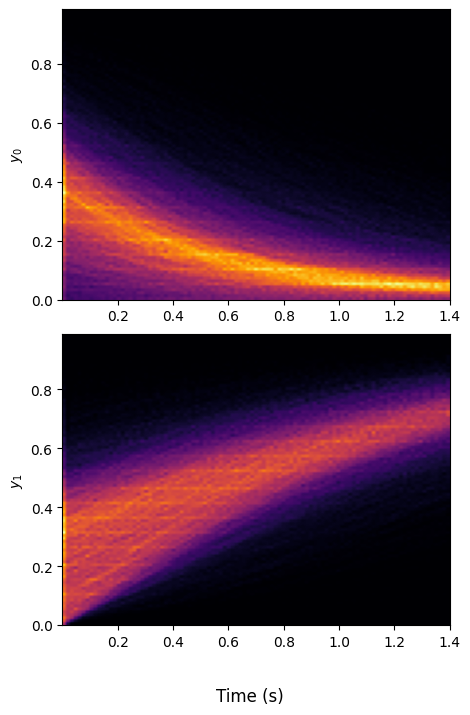

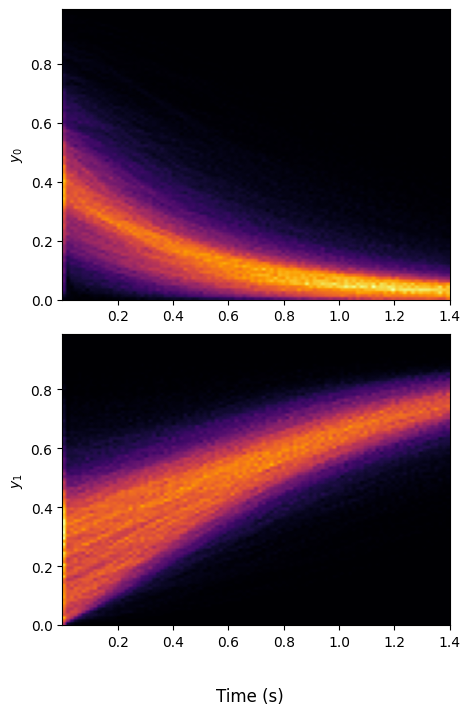

In [18]:
import pickle




#plot_histogram(true_paths, x_min, x_max, step_size)
plot_histogram2(y_, time_g_, n_time_per_trajectory)



plot_histogram2(ARFF_paths_, time_g_, n_time_per_trajectory)



output_dir = os.path.join(script_dir, 'histogram_data')

hist_data = {'traj_time': n_time_per_trajectory}
with open(os.path.join(output_dir, "ex6 - SIRGillespie ints.pkl"), 'wb') as f:
    pickle.dump(int_vars, f)

with open(os.path.join(output_dir, "ex6 - SIRGillespie true.pkl"), 'wb') as f:
    pickle.dump(y_, f)

with open(os.path.join(output_dir, "ex6 - SIRGillespie ARFF.pkl"), 'wb') as f:
    pickle.dump(ARFF_paths_, f)

with open(os.path.join(output_dir, "ex6 - SIRGillespie times.pkl"), 'wb') as f:
    pickle.dump(time_g_, f)